In [1]:
import sys; sys.path.append("../")

In [2]:
from dataset_wrappper import NewsData
from utils_train import transfer_batch_to_device
import os
from run_validation import load_model_for_eval
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast
import torch
import torch.nn.functional as F
from utils_evaluation import tokenizer_batch_decode
import numpy as np
import pickle
import tqdm

plt.style.reload_library()
plt.style.use('thesis_style')

%matplotlib inline

In [3]:
BATCH_SIZE = 32
DEVICE = "cuda:0"
CHECKPOINT_TYPE = "best" # else "best"
RESULT_DIR = Path("result-files")

In [4]:
cmap = pickle.load( open( RESULT_DIR / "thesis-cmap.pkl", "rb" ) )

In [5]:
data = NewsData(batch_size=BATCH_SIZE, tokenizer_name="roberta", dataset_name="ptb_text_only", max_seq_len=64)
validation_loader = data.val_dataloader(batch_size=BATCH_SIZE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

print(f"{len(validation_loader)} batches with batch size {BATCH_SIZE}")

Is file!
train 42068
validation 3370
test 3761
106 batches with batch size 32


In [6]:
from matplotlib import gridspec
import matplotlib
import math

def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

In [7]:
def get_clean_name(run_name):
    latent_size = run_name.split("-")[4][-2:]
    if "autoencoder" in run_name:
        FB = "autoencoder"
    else:
        FB = run_name.split("-")[6]
        if len(FB) == 3:
            FB += "0"
        FB = "FB-" + FB
    clean_name = f"NZ-{latent_size} | {FB}"
    return clean_name

In [8]:
PTB_run_name_paths = {}
for r in os.listdir("../Runs"):
    if "PTB" in r:
        path = Path("../Runs") / r / f"checkpoint-{CHECKPOINT_TYPE}.pth"
        PTB_run_name_paths[r] = path

for r in PTB_run_name_paths.keys():
    print(get_clean_name(r))

NZ-32 | FB-0.50
NZ-32 | FB-1.00
NZ-32 | FB-1.50
NZ-64 | FB-1.00
NZ-32 | FB-0.00
NZ-32 | autoencoder
NZ-64 | FB-0.50
NZ-64 | FB-1.50
NZ-64 | FB-0.00
NZ-64 | autoencoder
NZ-32 | FB-0.75
NZ-32 | FB-0.25
NZ-64 | FB-0.75
NZ-64 | FB-0.25


# Jenson Shannon distance between categorical distributions of prior versus posterior

The steps:
* JSD function

In [9]:
def JSD(p, q, log_p, log_q):
    """
    Jenson Shannon Divergence(P || Q)
    
    p, q: n-dimensional tensors both expected to contain log-probabilities
    Args:
        
    
    
    they should be batch x seq_len x vocab_size
    
    """
    
    # Mean distribution 
    m = 0.5 * (p + q)
    
    
    # JSD: symmtretical KL divergence
    # unreduced KL: p(x) * log ( p(x) / q(x) ) -> sum over probability dimension (last dim.)
    # kl div: input given is expected to contain log-probabilities and is not restricted to a 2D Tensor. 
    # The targets are interpreted as probabilities by default
    jsd = 0.5 * F.kl_div(log_p, m, reduction="none").sum(dim=-1) + \
          0.5 * F.kl_div(log_q, m, reduction="none").sum(dim=-1)
    
#     print(0.5 * F.kl_div(log_p, m, log_target=True, reduction="none"))
#     print(0.5 * F.kl_div(log_q, m, log_target=True, reduction="none"))
    
    return jsd

# batch x seq x vocab
x = torch.randn((1, 4, 10)) 
x_log_prob = F.log_softmax(x, dim=-1) # last dimension is probability dimension
x_prob = F.softmax(x, dim=-1)
# print(x_prob.sum(-1))

# batch x seq x vocab
y = torch.randn((1, 4, 10))
y_log_prob = F.log_softmax(y, dim=-1)
y_prob = F.softmax(y, dim=-1)
# print(y_prob.sum(-1))

# Unreduced -> reduce over batch dim
jsd = JSD(x_prob, y_prob, x_log_prob, y_log_prob) #.mean(dim=0)
jsd.mean()

tensor(0.2400)

In [13]:
AUTO_REGRESSIVE = False
MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'
RESULT_FILE = RESULT_DIR / f"result_JSD_over_seq_{MODE}.pickle"

N_exp = 5
max_batches = -1

# If already ran, do not run again
if os.path.exists(RESULT_FILE):
    print(f"Loading file {RESULT_FILE}, it existed.")
    results_jsd = pickle.load( open( RESULT_FILE, "rb" ) )

else:
    results_jsd = {}
    
for r_i, (r, p) in enumerate(PTB_run_name_paths.items()):

    print()
    print(f"Run {r_i}/{len(list(PTB_run_name_paths.keys()))}")
    print()
    
    if r in results_jsd:
        print("Have already done this one!")
        continue

    # collect the mean JSD between prior decoded and posterior decoded samples over 10 samples 
    # for the whole validation set
    jsd_over_seq = []
    jsd_post_post = []
    jsd_prior_post = []
    label_masks = []

    latent_size = int(r.split("-")[4][-2:])

    vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                    latent_size=latent_size, 
                                    add_latent_via_memory=True,
                                    add_latent_via_embeddings=False, 
                                    do_tie_weights=True, 
                                    do_tie_embedding_spaces=True,
                                    add_decoder_output_embedding_bias=False)


    N = len(validation_loader)
    with torch.no_grad():
        for batch_i, batch in enumerate(validation_loader):

            batch = transfer_batch_to_device(batch, DEVICE)

            logits_prior_batch = []
            logits_posterior_batch = []

            for exp_i in range(N_exp):
                print(f"Batch: {batch_i+1:3d}/{N} - Exp: {exp_i+1:3d}/{N_exp}", end="\r")

                for decode_sample_from_prior_mode in [False, True]:

                    vae_output = vae_model.forward(batch["input_ids"], 
                                                   1.0, 
                                                   batch["attention_mask"],
                                                   auto_regressive=AUTO_REGRESSIVE,
                                                    objective="beta-vae",
                                                    hinge_kl_loss_lambda=0.5,
                                                    return_latents=False,
                                                    return_log_q_z_x=False,
                                                    return_log_p_z=False,
                                                    return_mu_logvar=False,
                                                    return_exact_match=False,
                                                    return_cross_entropy=True,
                                                    return_embedding_distance=False,
                                                    reduce_seq_dim_embedding_loss="mean",
                                                    reduce_batch_dim_embedding_loss="mean",
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_logits=True, # <--
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_attention_to_latent=False,
                                                    return_attention_probs=False,
                                                    return_text_predictions=False,
                                                    tokenizer=None,
                                                    reduce_seq_dim_ce="none",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="none",
                                                    nucleus_sampling=False,
                                                    top_k=0,
                                                    top_p=0.9,
                                                    device_name="cuda:0",
                                                    decode_sample_from_prior=decode_sample_from_prior_mode) # <--

                    if decode_sample_from_prior_mode is True:
                        logits_prior_batch.append(vae_output["logits"].cpu())
                    else:
                        logits_posterior_batch.append(vae_output["logits"].cpu())


            # make a reordered posterior list, to compare posterior 
            # to posterior (and account for internal variability)
            re_order = list(np.arange(1, N_exp)) + [0]          
            logits_posterior_reordered = [logits_posterior_batch[i] for i in re_order]            

            # After cat operation, they matrices are [N_exp * batchsize x seq_len x vocab]
            # The log soft_max should operate on the last dimension
            log_probs_prior_batch = F.log_softmax(torch.cat(logits_prior_batch, dim=0), dim=-1)
            log_probs_posterior_batch = F.log_softmax(torch.cat(logits_posterior_batch, dim=0), dim=-1)
            log_probs_posterior_reordered_batch = F.log_softmax(torch.cat(logits_posterior_reordered, dim=0), dim=-1)
            
            probs_prior_batch = F.softmax(torch.cat(logits_prior_batch, dim=0), dim=-1)
            probs_posterior_batch = F.softmax(torch.cat(logits_posterior_batch, dim=0), dim=-1)
            probs_posterior_reordered_batch = F.softmax(torch.cat(logits_posterior_reordered, dim=0), dim=-1)
            
            # JSD returns [N_exp * batchsize x seq_len]
            jsd_prior_posterior = JSD(probs_posterior_batch, probs_prior_batch, log_probs_posterior_batch, log_probs_prior_batch)
            jsd_posterior_posterior = JSD(probs_posterior_batch, probs_posterior_reordered_batch, log_probs_posterior_batch, log_probs_posterior_reordered_batch)
            jsd_dif = jsd_prior_posterior - jsd_posterior_posterior
            
            # Take into account the different sequence lengths, correct for that when averaging
            labels = batch["input_ids"].cpu()[:, 1:].contiguous()  # skip <s> token
            label_mask = (labels != 1).float().repeat(N_exp, 1) # pad token is int 1
            #label_mask_sum_batch_exp = label_mask.sum(dim=0) # sum over the batch, N_exp dim
            # mean_jsd_dif = jsd_dif.sum(dim=0) / label_mask_sum_batch_exp
            
            jsd_over_seq.append(jsd_dif)
            jsd_post_post.append(jsd_posterior_posterior)
            jsd_prior_post.append(jsd_prior_posterior)
            label_masks.append(label_mask)

            if batch_i == max_batches - 1:
                break

            # ------- END BATCH EXP ---------

        # -------- END ALL BATCHES ----------

    # Maximum sequence length, needed for padding
    max_len = max([t.shape[1] for t in jsd_over_seq])

    # pad all to have the same length 
    jsd_over_seq = [F.pad(x, (0, max_len-x.shape[1])) for x in jsd_over_seq]
    jsd_over_seq = torch.cat(jsd_over_seq, dim=0)
#     jsd_over_seq = jsd_over_seq.mean(dim=0)

    jsd_post_post = [F.pad(x, (0, max_len-x.shape[1])) for x in jsd_post_post]
    jsd_post_post = torch.cat(jsd_post_post, dim=0)
    
    jsd_prior_post = [F.pad(x, (0, max_len-x.shape[1])) for x in jsd_prior_post]
    jsd_prior_post = torch.cat(jsd_prior_post, dim=0)

    label_masks = [F.pad(x, (0, max_len-x.shape[1])) for x in label_masks]
    label_masks = torch.cat(label_masks, dim=0)

    results_jsd[r] ={
        "jsd_over_seq": jsd_over_seq,
        "jsd_post_post": jsd_post_post,
        "jsd_prior_post": jsd_prior_post,
        "label_masks": label_masks
    }

    pickle.dump( results_jsd, open( RESULT_FILE, "wb" ))

Loading file result-files/result_JSD_over_seq_TF.pickle, it existed.

Run 0/14

Have already done this one!

Run 1/14

Have already done this one!

Run 2/14

Have already done this one!

Run 3/14

Have already done this one!

Run 4/14

Have already done this one!

Run 5/14

Have already done this one!

Run 6/14

Have already done this one!

Run 7/14

Have already done this one!

Run 8/14

Have already done this one!

Run 9/14

Have already done this one!

Run 10/14

Have already done this one!

Run 11/14

Have already done this one!

Run 12/14

Have already done this one!

Run 13/14

Have already done this one!


In [14]:
for k, v in results_jsd.items():
    results_jsd[k]["jsd_over_seq_weighted_avg"] = v["jsd_over_seq"].sum(dim=0) / v["label_masks"].sum(dim=0)
    results_jsd[k]["jsd_prior_post_seq_weighted_avg"] = v["jsd_prior_post"].sum(dim=0) / v["label_masks"].sum(dim=0)
    results_jsd[k]["jsd_post_post_seq_weighted_avg"] = v["jsd_post_post"].sum(dim=0) / v["label_masks"].sum(dim=0)
    results_jsd[k]["hist"] = v["label_masks"].sum(dim=0)
    
pickle.dump( results_jsd, open( RESULT_FILE, "wb" ))

## Plot for not dependent on sequence position (22 feb)

In [25]:
test_result = results_jsd["2021-02-03-PTB-latent32-FB-0.5-run-09:31:02"]

jsd_dif = test_result["jsd_over_seq"]
print(len(jsd_dif))
print(len(validation_loader) * N_exp * BATCH_SIZE)

16850
16800


In [12]:
# # import pickle

# # cmap = pickle.load( open( "thesis_cmap.pkl", "rb" ) )

# for i, (n, r) in enumerate(results_jsd.items()):
#     fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 6), gridspec_kw={"width_ratios":[1, 0.03], 
#                                                                            "height_ratios":[1, 0.5, 0.5, 0.5]})
    
#     plt.suptitle(get_clean_name(n))
    
#     jsd_dif_data = np.abs(r["jsd_over_seq_weighted_avg"][:30].unsqueeze(0).numpy())
#     jsd_prior_post_data = np.abs(r["jsd_prior_post_seq_weighted_avg"][:30].unsqueeze(0).numpy())
#     jsd_post_post = np.abs(r["jsd_post_post_seq_weighted_avg"][:30].unsqueeze(0).numpy())
    
#     all_data = np.concatenate([jsd_dif_data, jsd_prior_post_data, jsd_post_post])
#     min_, max_ = np.min(all_data), np.max(all_data)
    
#     ax[1, 0].set_title("JSD(post||prior) - JSD(post||post')", fontsize=12)
#     im1 = ax[1, 0].imshow(jsd_dif_data, vmin=min_, vmax=max_)
#     ax[2, 0].set_title("JSD(post||prior)", fontsize=12)
#     im2 = ax[2, 0].imshow(jsd_prior_post_data, vmin=min_, vmax=max_)
#     ax[3, 0].set_title("JSD(post||post')", fontsize=12)
#     im3 = ax[3, 0].imshow(jsd_post_post, vmin=min_, vmax=max_)
    
#     for i in range(1, 4):
#         ax[i, 0].set_axis_off()
#         ax[i, 0].set_yticks([])
    
#     plt.colorbar(im1, cax=ax[1, 1])
#     plt.colorbar(im2, cax=ax[2, 1])
#     plt.colorbar(im3, cax=ax[3, 1])
    
#     # Histogram of counts of elements at sequence positions
#     counts = r["hist"].numpy()[:30].astype(float) / N_exp
#     bins = np.arange(30).astype(float)
#     counts_, bins_, _ = ax[0, 0].hist(bins, bins=len(counts), weights=counts, range=(min(bins), max(bins)))
    
#     fig.delaxes(ax[0, 1])
    
#     plt.tight_layout() 
#     plt.show()

In [13]:

# from matplotlib.gridspec import  GridSpec

# min_, max_ = 1000, -1000
# for n, r in results_jsd.items():
#     low, high = r["jsd_over_seq"].min(), r["jsd_over_seq"].max()
    
#     if low < min_:
#         min_ = low
    
#     if high > max_:
#         max_ = high

# # print("min val, max val", min_, max_)
# fig, ax = plt.subplots(nrows=14, ncols=4, figsize=(15, 15), gridspec_kw={"width_ratios":[1, 0.05, 1, 0.05]}) #, gridspec_kw={"width_ratios":[1, 1, 0.05]}

# # print("JSD(post||prior) - JSD(post||post_prime)")

# for i, (n, r) in enumerate(results_jsd.items()):
#     row = i % 7 
#     col = i // 7
    
#     row = row*2+1
    
#     if col == 1:
#         col = 2
        
# #     print(row, col)
    
#     im = ax[row, col].imshow(np.abs(r["jsd_over_seq_weighted_avg"][:30]).unsqueeze(0).numpy())  #, vmin=min_, vmax=max_ 

#     ax[row, col].set_axis_off()
    
#     ax[row, col].set_yticks([])
    
#     plt.colorbar(im, cax=ax[row, col+1])
    
#     counts = r["hist"].numpy()[:30].astype(float) / N_exp
#     bins = np.arange(30).astype(float)
    
# #     print(counts.shape, bins.shape)

#     # recover
#     # centroids = (bins[1:] + bins[:-1]) / 2 
#     counts_, bins_, _ = ax[row-1, col].hist(bins, bins=len(counts),
#                                             weights=counts, range=(min(bins), max(bins))) 
#     ax[row-1, col].set_title(get_clean_name(n), fontsize=12)
    
# for i in range(14): # change back to 6
#     if i % 2 == 0:
#         fig.delaxes(ax[i, 1])
#         fig.delaxes(ax[i, 3])
# # plt.colorbar(im0, cax=ax[-1, 2]) # uncomment for colorbar
# plt.tight_layout() 
# plt.suptitle("JSD(post||prior) - JSD(post||post')", size=20, y=1.03)
# plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


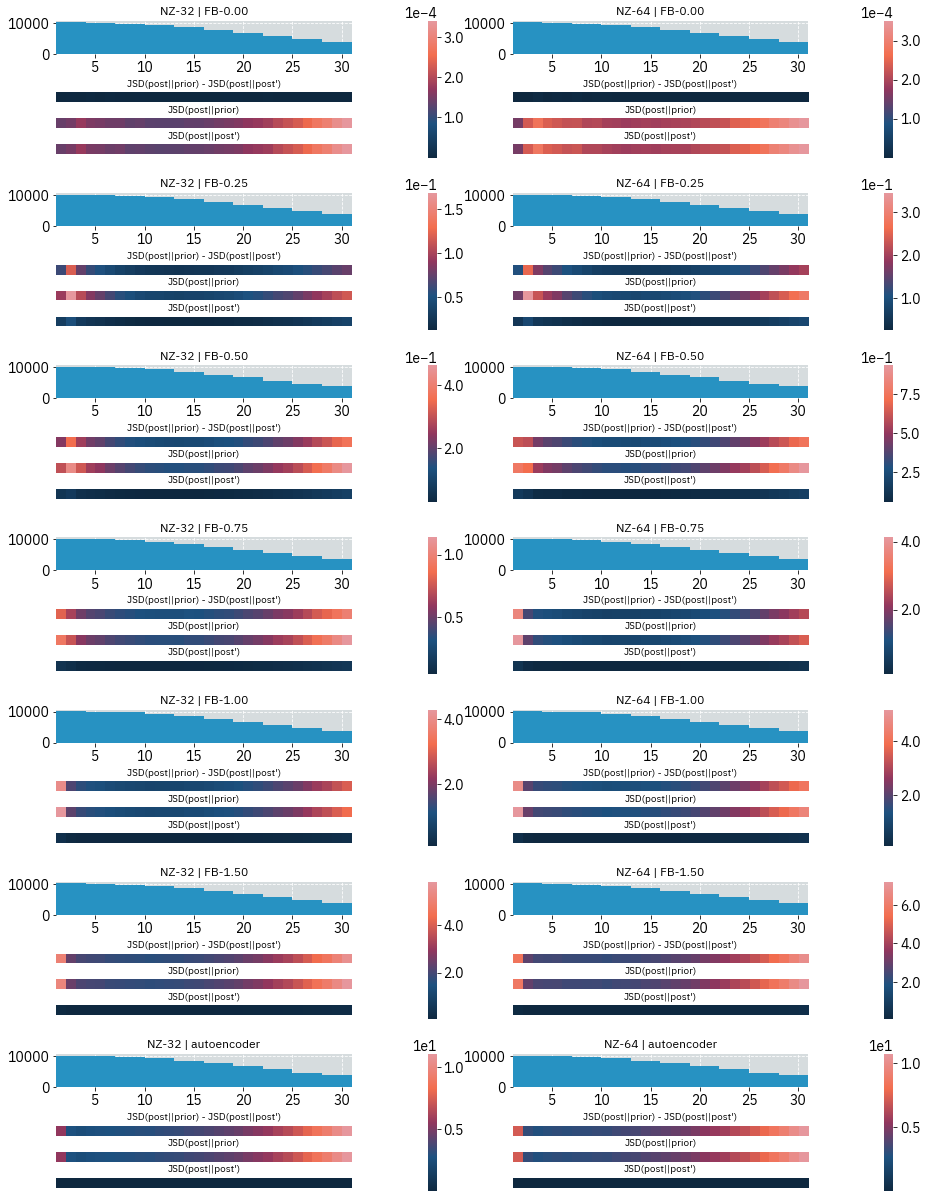

In [16]:



order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]

height_ratios = [1 if i % 6 != 0 else 2 for i in range(7*6)]

gs = gridspec.GridSpec(7*6, 4, width_ratios=[1, 0.03, 1, 0.03], height_ratios=height_ratios, wspace=0.5, hspace=0.5) # 

fig = plt.figure(figsize=(15, 22))

max_seq_len = 30

for j in range(len(order)):
    
    i = j % 7
    
    run_name = order[j]
    r = results_jsd[run_name]
    
    if "latent32" in run_name:
        col = 0
    else:
        col = 2
        
    start_row = i * 6

    hist_ax = fig.add_subplot(gs[start_row, col])
    jds_dif_ax = fig.add_subplot(gs[start_row+2, col])
    prior_post_ax = fig.add_subplot(gs[start_row+3, col])
    post_post_ax = fig.add_subplot(gs[start_row+4, col])
    colorbar_ax = fig.add_subplot(gs[start_row:start_row+5, col+1])
    
    jsd_dif_data = np.abs(r["jsd_over_seq_weighted_avg"][:max_seq_len].unsqueeze(0).numpy())
    jsd_prior_post_data = np.abs(r["jsd_prior_post_seq_weighted_avg"][:max_seq_len].unsqueeze(0).numpy())
    jsd_post_post = np.abs(r["jsd_post_post_seq_weighted_avg"][:max_seq_len].unsqueeze(0).numpy())
    
    all_data = np.concatenate([jsd_dif_data, jsd_prior_post_data, jsd_post_post])
    min_, max_ = np.min(all_data), np.max(all_data)
    
    # min_, max_ = 0, 5 # overwrite
    
    im1 = jds_dif_ax.imshow(jsd_dif_data, vmin=min_, vmax=max_, cmap=cmap)
    jds_dif_ax.set_title("JSD(post||prior) - JSD(post||post')", size=10)
    
    im2 = prior_post_ax.imshow(jsd_prior_post_data, vmin=min_, vmax=max_, cmap=cmap)
    prior_post_ax.set_title("JSD(post||prior)", size=10)
    
    im3 = post_post_ax.imshow(jsd_post_post, vmin=min_, vmax=max_, cmap=cmap)
    post_post_ax.set_title("JSD(post||post')", size=10)
    
    jds_dif_ax.set_axis_off()
    prior_post_ax.set_axis_off()
    post_post_ax.set_axis_off()
    
    jds_dif_ax.set_yticks([])
    prior_post_ax.set_yticks([])
    post_post_ax.set_yticks([])
    
    plt.colorbar(im1, cax=colorbar_ax, format=OOMFormatter(orderOfMagnitude(max_), mathText=False))

    counts = r["hist"].numpy()[:max_seq_len].astype(float) / N_exp
    bins = np.arange(1, max_seq_len+1).astype(float)
    hist_ax.hist(bins, weights=counts, range=(1, max_seq_len+1))
    hist_ax.set_title(get_clean_name(run_name), fontsize=12)
    hist_ax.set_xlim([1, max_seq_len+1])
    #hist_ax.set_axis_off()
    #hist_ax.set_yticks([])
    
plt.savefig(RESULT_DIR / "JSF_posterior_prior_TF.png", dpi=300, bbox="tight_inches")
plt.show()

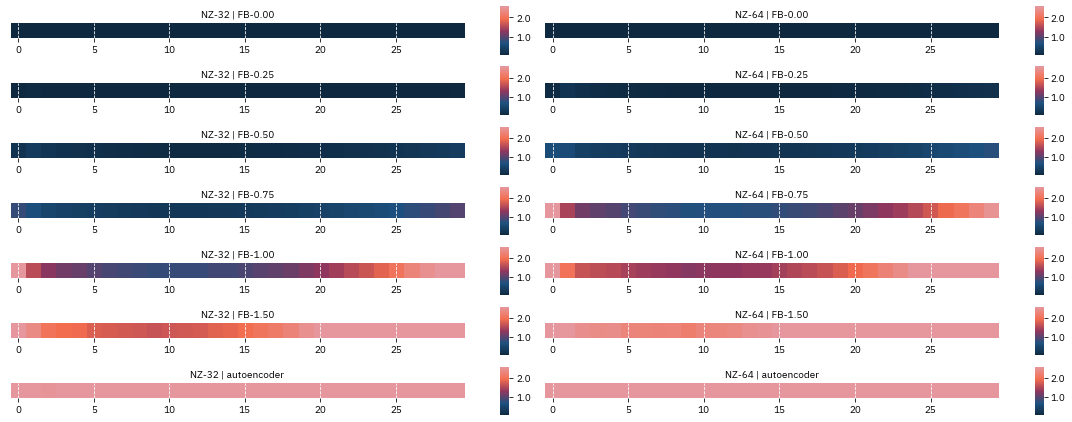

In [17]:
from matplotlib import gridspec

order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]

max_seq_len = 30
same_scale = True

for n, r in results_jsd.items():
    vmin_all = np.min(r["jsd_over_seq_weighted_avg"].numpy())
    vmax_all = np.max(r["jsd_over_seq_weighted_avg"].numpy())
    
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(15, 6), gridspec_kw={"width_ratios":[1, 0.02, 1, 0.02]})

for j in range(len(order)):
    row = j % 7
    
    run_name = order[j]
    r = results_jsd[run_name]
    
    if "latent32" in run_name:
        col = 0
    else:
        col = 2
            
    jsd_dif_data = r["jsd_over_seq_weighted_avg"][:max_seq_len].unsqueeze(0).numpy()
    
    if same_scale:
        vmin, vmax = vmin_all, vmax_all
    else:
        vmin, vmax = np.min(jsd_dif_data), np.max(jsd_dif_data)
    
    im = ax[row, col].imshow(jsd_dif_data, vmin=vmin, vmax=vmax, cmap=cmap)
    ax[row, col].set_title(get_clean_name(run_name), size=10)
    ax[row, col].set_yticks([])
    ax[row, col].tick_params(labelsize=10) 
#     ax[row, col].set_axis_off()
#     ax[row, col].set_yticks([])
    
    cbar = plt.colorbar(im, cax=ax[row, col+1], format=OOMFormatter(orderOfMagnitude(vmax), mathText=False))
    ax[row, col+1].tick_params(labelsize=10) 

plt.tight_layout()
#plt.savefig(RESULT_DIR / f"JSF_posterior_prior_TF_simple_same_scale_{same_scale}.png", dpi=300, bbox="tight_inches")
plt.show()

## Improvements 22 Feb

In [10]:
AUTO_REGRESSIVE = False
MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'
RESULT_FILE = RESULT_DIR / f"result_JSD_over_seq_{MODE}_23feb.pickle"

N_exp = 10
max_batches = 20

# If already ran, do not run again
if os.path.exists(RESULT_FILE):
    print(f"Loading file {RESULT_FILE}, it existed.")
    results_jsd = pickle.load( open( RESULT_FILE, "rb" ) )

else:
    results_jsd = {}
    
for r_i, (r, p) in enumerate(PTB_run_name_paths.items()):

    print()
    print(f"Run {r_i}/{len(list(PTB_run_name_paths.keys()))}")
    print()
    
    if r in results_jsd:
        print("Have already done this one!")
        continue

    # collect the mean JSD between prior decoded and posterior decoded samples over 10 samples 
    # for the whole validation set
    jsd_over_seq = []
    jsd_post_post = []
    jsd_prior_post = []
    label_masks = []

    latent_size = int(r.split("-")[4][-2:])

    vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                    latent_size=latent_size, 
                                    add_latent_via_memory=True,
                                    add_latent_via_embeddings=False, 
                                    do_tie_weights=True, 
                                    do_tie_embedding_spaces=True,
                                    add_decoder_output_embedding_bias=False)


    N = len(validation_loader) if max_batches < 0 else max_batches
    with torch.no_grad():
        for batch_i, batch in enumerate(validation_loader):

            batch = transfer_batch_to_device(batch, DEVICE)

            logits_prior_batch = []
            logits_posterior_batch = []

            for exp_i in range(N_exp):
                print(f"Batch: {batch_i+1:3d}/{N} - Exp: {exp_i+1:3d}/{N_exp}")

                for decode_sample_from_prior_mode in [False, True]:

                    vae_output = vae_model.forward(batch["input_ids"], 
                                                   1.0, 
                                                   batch["attention_mask"],
                                                   auto_regressive=AUTO_REGRESSIVE,
                                                    objective="beta-vae",
                                                    hinge_kl_loss_lambda=0.5,
                                                    return_latents=False,
                                                    return_log_q_z_x=False,
                                                    return_log_p_z=False,
                                                    return_mu_logvar=False,
                                                    return_exact_match=False,
                                                    return_cross_entropy=True,
                                                    return_embedding_distance=False,
                                                    reduce_seq_dim_embedding_loss="mean",
                                                    reduce_batch_dim_embedding_loss="mean",
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_logits=True, # <--
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_attention_to_latent=False,
                                                    return_attention_probs=False,
                                                    return_text_predictions=False,
                                                    tokenizer=None,
                                                    reduce_seq_dim_ce="none",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="none",
                                                    nucleus_sampling=False,
                                                    top_k=0,
                                                    top_p=0.9,
                                                    device_name="cuda:0",
                                                    decode_sample_from_prior=decode_sample_from_prior_mode) # <--

                    if decode_sample_from_prior_mode is True:
                        logits_prior_batch.append(vae_output["logits"].cpu())
                    else:
                        logits_posterior_batch.append(vae_output["logits"].cpu())


            # make a reordered posterior list, to compare posterior 
            # to posterior (and account for internal variability)
            re_order = list(np.arange(1, N_exp)) + [0]          
            logits_posterior_reordered = [logits_posterior_batch[i] for i in re_order]
            
            x_jsd_post_prior_all = []
            x_jsd_post_post_all = []
            x_jsd_dif_all = []
            
            for b in range(len(logits_prior_batch)):
                print("Calculating JSD batch {}".format(b))
                log_probs_prior = F.log_softmax(logits_prior_batch[b], dim=-1)
                log_probs_post = F.log_softmax(logits_posterior_batch[b], dim=-1)
                log_probs_post_2 = F.log_softmax(logits_posterior_reordered[b], dim=-1)
                
                probs_prior = F.softmax(logits_prior_batch[b], dim=-1)
                probs_post = F.softmax(logits_posterior_batch[b], dim=-1)
                probs_post_2 = F.softmax(logits_posterior_reordered[b], dim=-1)
                
                x_jsd_post_prior = JSD(probs_post, probs_prior, log_probs_post, log_probs_prior)
                x_jsd_post_post = JSD(probs_post, probs_post_2, log_probs_post, log_probs_post_2)
                x_jsd_dif = x_jsd_post_prior - x_jsd_post_post
                
                x_jsd_post_prior_all.append(x_jsd_post_prior)
                x_jsd_post_post_all.append(x_jsd_post_post)
                x_jsd_dif_all.append(x_jsd_dif)
            
            # Take into account the different sequence lengths, correct for that when averaging
            labels = batch["input_ids"].cpu()[:, 1:].contiguous()  # skip <s> token
            label_mask = (labels != 1).float() #.repeat(N_exp, 1) # pad token is int 1
            #label_mask_sum_batch_exp = label_mask.sum(dim=0) # sum over the batch, N_exp dim
            # mean_jsd_dif = jsd_dif.sum(dim=0) / label_mask_sum_batch_exp
            
            jsd_over_seq.append(x_jsd_dif_all)
            jsd_post_post.append(x_jsd_post_post_all)
            jsd_prior_post.append(x_jsd_post_prior_all)
            label_masks.append(label_mask)

            if batch_i == max_batches - 1:
                break

            # ------- END BATCH EXP ---------

        # -------- END ALL BATCHES ----------

        results_jsd[r] ={
            "jsd_over_seq": jsd_over_seq,
            "jsd_post_post": jsd_post_post,
            "jsd_prior_post": jsd_prior_post,
            "label_masks": label_masks
        }
    
        print("*"*40)
        print("Dumping results!")
        print("*"*40)

        pickle.dump( results_jsd, open( RESULT_FILE, "wb" ))
    
    # break # <-- only perform one run for now... 

Loading file result-files/result_JSD_over_seq_TF_23feb.pickle, it existed.

Run 0/14

Have already done this one!

Run 1/14

Have already done this one!

Run 2/14

Have already done this one!

Run 3/14

Have already done this one!

Run 4/14

Have already done this one!

Run 5/14

Have already done this one!

Run 6/14

Have already done this one!

Run 7/14

Have already done this one!

Run 8/14

Have already done this one!

Run 9/14

Have already done this one!

Run 10/14

Have already done this one!

Run 11/14

Have already done this one!

Run 12/14

Have already done this one!

Run 13/14

Have already done this one!


In [11]:
test_results = results_jsd["2021-02-03-PTB-latent32-FB-0.5-run-09:31:02"]

# test_results["jsd_over_seq"] is a list of list

# the outer list is the batch dimension
# the inner list is the experiment dimension

plot_results = {}
for run_name, test_results in results_jsd.items():

    masks = test_results["label_masks"]

    all_positions = []
    all_rel_positions = []
    all_relative_jsd_dif = []

    # Loop over batches
    for i, jsd_dif in enumerate(test_results["jsd_over_seq"]):

        # Average over experiments
        avg_jsd_dif = torch.abs(torch.stack(jsd_dif, dim=0).mean(dim=0)) # batch x max_seq_len in batch

        # Move all sequences to the 0, 1-range
        for seq_i in range(len(avg_jsd_dif)):

            seq_mask = masks[i][seq_i, :]
            avg_jsd_dif_seq = avg_jsd_dif[seq_i, :]

            x = (seq_mask == 0).nonzero(as_tuple=True)[0]

            if len(x) != 0:
                N_elem = x[0].item()
            else:
                N_elem = len(seq_mask)

            positions = torch.arange(1, N_elem+1) 
            relative_positions = positions / N_elem
            # avg_jsd_dif_seq /= float(N_elem)
            avg_jsd_dif_seq = avg_jsd_dif_seq[:N_elem]

            all_positions.extend(positions.tolist())
            all_rel_positions.extend(relative_positions.tolist())
            all_relative_jsd_dif.extend(avg_jsd_dif_seq.tolist())
    
    plot_results[run_name] = {
        "relative_positions": all_rel_positions,
        "absolute_positions": all_positions,
        "jsd_dif_vals": all_relative_jsd_dif
    }

In [12]:
# from scipy import stats 
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = (10, 6)

# N_bins = 100

# for run_name, test_results in plot_results.items():
#     print(get_clean_name(run_name))
    
#     bin_means, bin_edges, bin_ids = stats.binned_statistic( all_positions, all_relative_jsd_dif, 
#                                                            statistic ='mean', bins = N_bins)
#     plt.imshow(bin_means[None, :], aspect=3.0)
#     plt.show()
    
#     plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5, label='binned statistic of data')
#     plt.show()
    


# import seaborn as sns; sns.set()

# plt.scatter(all_positions, all_relative_jsd_dif, alpha=0.1)
# plt.show()

# # _ = plt.hist(all_positions, bins=30, weights=all_relative_jsd_dif, density=True)


# # hist, bins = np.histogram(all_positions, bins=30, weights=all_relative_jsd_dif)

# # print(hist)
# # print(bins)

# # from scipy import stats 

# # print("\nbinned_statistic for mean : \n", )  

# # bins = numpy.linspace(0, 1, 30)

# # bin_means = (np.histogram(data, bins, weights=data)[0] /
# #              np.histogram(data, bins)[0])
# 

# 
# # plt.xticks(bin_edges[:-1])
# plt.show()


# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5, label='binned statistic of data')


# plt.show()

RELATIVE_POSITIONS
Same scale!


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


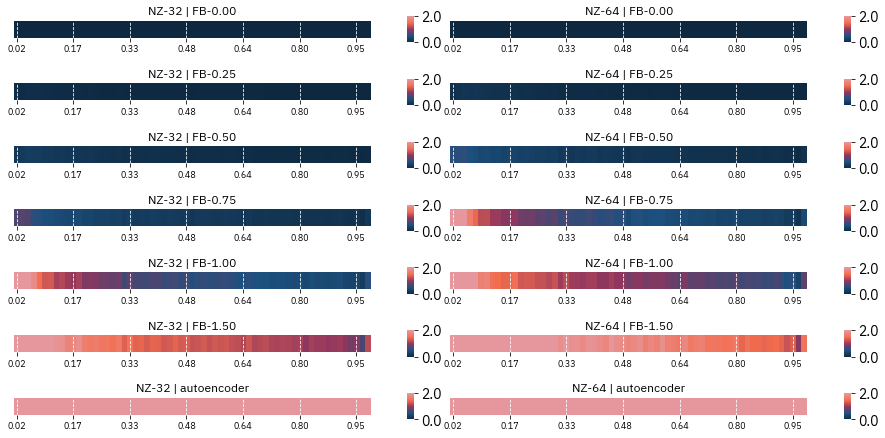

ABSOLUTE_POSITIONS
Same scale!


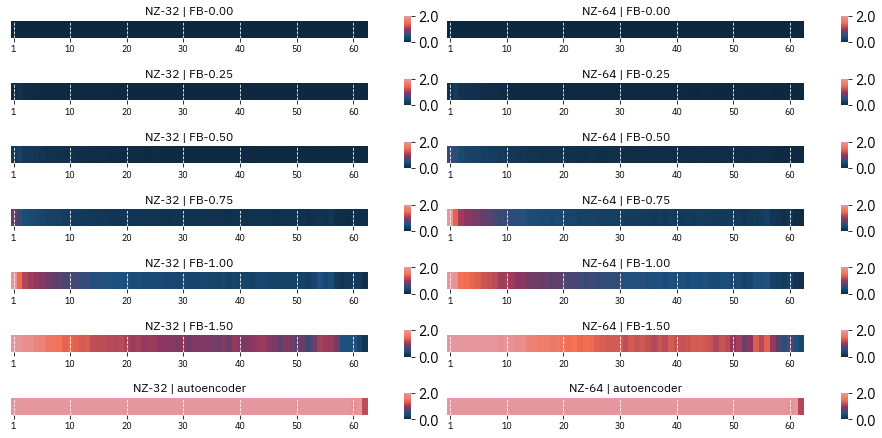

RELATIVE_POSITIONS
Different scale


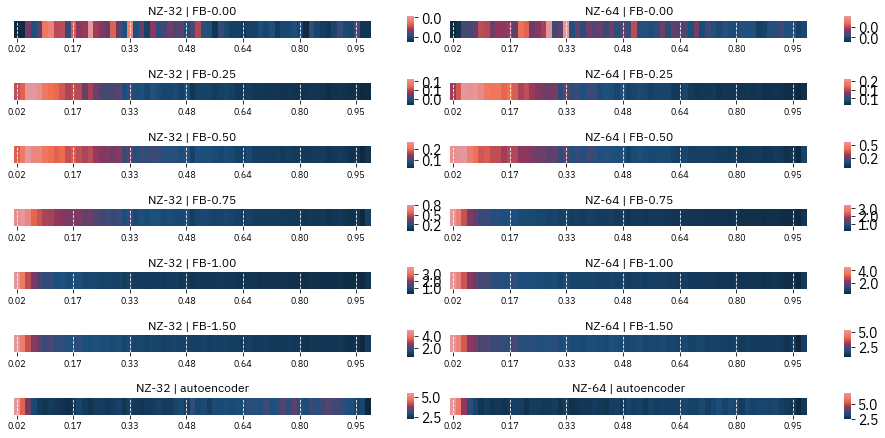

ABSOLUTE_POSITIONS
Different scale


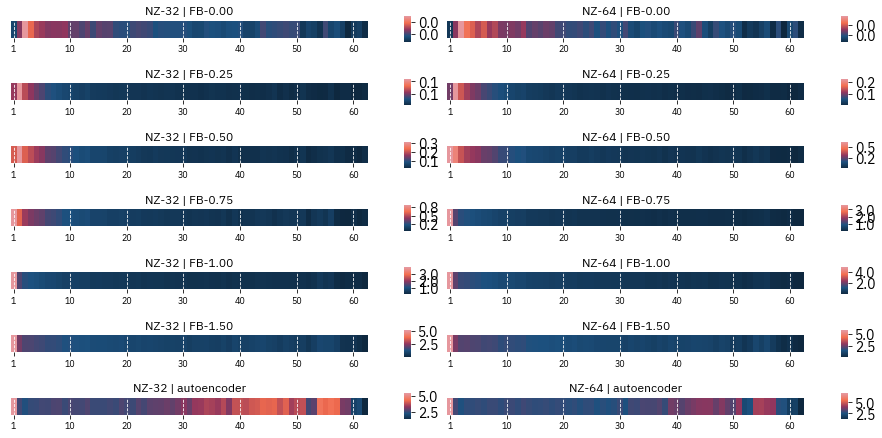

In [13]:
from scipy import stats 


order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]


plt.rcParams["figure.figsize"] = (10, 6)

N_bins = 63

same_scale = True


for same_scale in [True, False]:

    for mode in ["relative_positions", "absolute_positions"]:
        print(mode.upper())
        if same_scale:
            print("Same scale!")
        else:
            print("Different scale")

        fig, axs = plt.subplots(nrows=7*2, ncols=4, figsize=(15, 8), gridspec_kw={"width_ratios":[1, 0.02, 1, 0.02]})

        for j in range(len(order)):
            i = j % 7
            start_row = i * 2

            # Get results
            run_name = order[j]
            results = plot_results[run_name]

            # Calculate binned stats
            x = results[mode]
            y = results["jsd_dif_vals"]
            bin_means, bin_edges, bin_ids = stats.binned_statistic(x, y, statistic ='mean', bins = N_bins)

            # Which column
            if "latent32" in run_name:
                col = 0
            else:
                col = 2

            # Plot
            axs[start_row, col].set_title(f"{get_clean_name(run_name)}", fontsize=12)

            if same_scale:
                im0 = axs[start_row, col].imshow(bin_means[None, :], aspect=3.0, vmin=0.0, vmax=2.0, cmap=cmap) #, vmin=0, vmax=0.5
            else:
                im0 = axs[start_row, col].imshow(bin_means[None, :], aspect=3.0, cmap=cmap) #, vmin=0, vmax=0.5

            # Y-TICKS
            axs[start_row, col].set_yticks([])

            # X-TICKS
            locs, labels = np.arange(N_bins)[::10], bin_edges[:-1][::10]

            if mode == "relative_positions":
                labels = [f"{l:.2f}" for l in labels]
            else:
                labels = [f"{int(l)}" for l in labels]

            axs[start_row, col].set_xticks(locs) 
            axs[start_row, col].set_xticklabels(labels, fontsize=9)

            # Color bar
            cbar = plt.colorbar(im0, cax=axs[start_row, col+1], format=OOMFormatter(0, mathText=False)) #

            fig.delaxes(axs[start_row+1, col+1])
            fig.delaxes(axs[start_row+1, col])

#         fig.suptitle(mode)
        plt.savefig(RESULT_DIR / f"NEW_JSD_over_seq_{mode}_same_scale_{same_scale}.png", dpi=300, bbox="tight_inches")
        plt.show()